In [58]:
import dataset_models
import imp
imp.reload(dataset_models)

import pandas as pd
from dataset_models import Umi, session, db, Dataset, UmiGeneId, GoTerm, NcbiGene, Segment

#sql boilerplate
rsq = pd.read_sql_query
sq = session.query

In [12]:
getDatasetId = lambda x:int(x[:8])

In [13]:
dataset = "29045011805220233"

In [3]:
import scipy.stats as stats

In [4]:
import os
import numpy as np


In [5]:
nm = dataset

In [6]:
import wget

In [60]:
import urllib

In [61]:
with urllib.request.urlopen("http://35.237.243.111:5000/segmentations/29045011805220233/annotations/") as f:
    content = f.read().decode('utf-8')

In [32]:
from urllib.request import urlopen

In [34]:
import json

In [63]:
url ="http://35.237.243.111:5000/segmentations/29045011805220233/annotations/"
json_url = urlopen(url)
data = json.loads(json_url.read())


In [80]:

out_folder = os.path.join(f"/data/tmp/{nm}")
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)

#produce a small gzip output file having x,y,t for each point
umi_ids_path = os.path.join(out_folder,"umi_ids.json.gz")

import gzip
from dataset_models import Umi, session, db, Dataset, GeneGoTerm, UmiGeneId, GoTerm, NcbiGene, Segment
rsq = pd.read_sql_query
sq = session.query

with gzip.open(umi_ids_path,"w") as f:
    f.write(
        bytes(rsq(sq(Umi).filter(Umi.dsid==getDatasetId(nm)).statement,db).to_json(orient="columns"),'utf-8'
    ))


return {
     "umi_ids":umi_ids_path
}

SyntaxError: 'return' outside function (<ipython-input-80-bb90c69a1c50>, line 19)

In [81]:
cfpath = os.path.join(out_folder,"coords.json.gz")

In [88]:
content = gzip.open(afpath).read()

In [87]:
afpath = os.path.join(out_folder,"annotations.json.gz")


In [89]:
content2 = gzip.open(umi_ids_path).read()

In [90]:
content[:100]

b'{"features": [[228057, -1, -1, -1, "N", 14825], [228056, -1, -1, -1, "N", 34009], [13357, -1, -1, -1'

In [77]:
out = rsq(sq(Umi).filter(Umi.dsid==getDatasetId(nm)).statement,db).to_json(orient="values")

In [85]:
content2[:100]

b'[[1,29045011,0,4.4292977792,1.3590231387,14825,1,-1,"N",-1],[2,29045011,1,-4.5781035674,-0.204734992'

In [ ]:
[e["eval0"] for e in data.values()][::100]

In [ ]:
out_folder = os.path.join(
    f"/data/dd-analysis/datasets/{nm}/segmentations/")
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)


umis= rsq(sq(Umi).filter(Umi.dsid==getDatasetId(nm)).statement,db).rename({"id":"umi_id"},axis="columns").set_index("umi_id")
# initialize segment information

segment_umis = rsq( sq(Umi.dsid,Umi.id.label("umi_id"),Umi.x,Umi.y,Segment.id.label("seg_id")).filter(Umi.dsid==getDatasetId(nm)).join(Segment).statement,db)

seg_counts = segment_umis.seg_id.value_counts()

segs = segment_umis.join(segment_umis.seg_id.value_counts().rename("seg_umi_count"), on = "seg_id").loc[lambda x: x.seg_umi_count>1]
segs_by_id = segs.set_index("seg_id")

print("computing eigensystems")
#compute normalized distances to cell centers using eigenvectors of the covariance matrix
esys = segs_by_id.groupby("seg_id").apply(lambda g: np.linalg.eig(np.cov(*g[["x","y"]].values.T)))
emeans = segs_by_id[["x","y"]].groupby("seg_id").mean()

#USEFUL CODE... not used
# proj_dist = segs_by_id.reset_index().set_index("umi_id").apply(
#     lambda u:(lambda e: (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,0])/(e[0][0]**.5))**2 + \
#                         (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,1])/(e[0][1]**.5))**2)(esys.loc[u.seg_id]),axis=1)\
#     .rename("transformed_dist")


# segs_with_dists = segs_by_id.join(proj_dist.reset_index().set_index("umi_id"),on="umi_id")
# segs_with_dists = segs_with_dists.join(umis[["total_reads"]],on="umi_id")
s_mean_xs =  segment_umis.groupby("seg_id").x.mean()
s_mean_ys =  segment_umis.groupby("seg_id").y.mean()



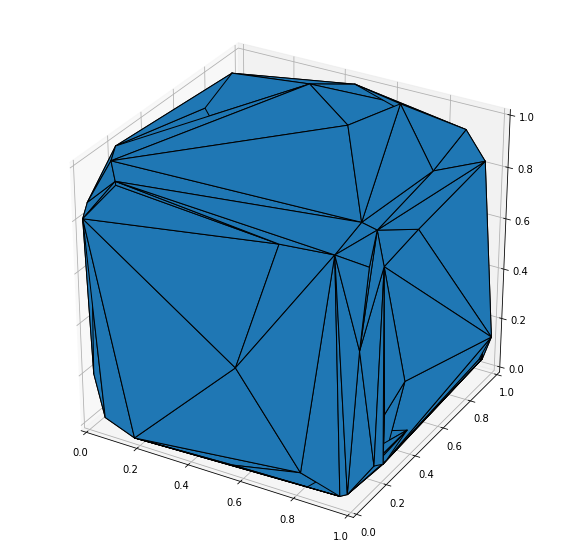

In [56]:
session.rollback()

In [59]:
dbsegs = sq(Segment).filter(Segment.dsid == getDatasetId(nm)).all()
for s in dbsegs[::100]:

    s.n_umis = int(seg_counts.loc[int(s.id)])
    s.meanx = s_mean_xs.get(s.id)
    s.meany = s_mean_ys.get(s.id)


    
    if ( esys.index.contains(s.id)):
        s.evec0x = esys.loc[s.id][1][0][0]
        s.evec0y = esys.loc[s.id][1][1][0]
        s.evec1x = esys.loc[s.id][1][0][1]
        s.evec1y = esys.loc[s.id][1][1][1]
        s.eval0 =  esys.loc[s.id][0][0]
        s.eval1 =  esys.loc[s.id][0][1]
        
        print(s.evec0x)

    session.add(s)


session.commit()

-0.8885898457607102
0.9582362647812797
-0.9866082535188568
-0.743605433351248
-0.8805762843618099
-0.9262642589492738
0.7701195757639072
0.9705966879793653
-0.9995346917334045
-0.9442486192072544
-0.983590571087987


In [92]:
winning_path =  os.path.join( f"/data/dd-analysis/datasets/{nm}/segmentations/", "winning_pixels.csv")
winning_segments_df = pd.read_csv(winning_path, index_col=["x","y"])
winning_nested = winning_segments_df.reset_index("y").groupby("x").apply(lambda x:  x.set_index("y").to_dict()['segment']).to_dict()


In [99]:
%%time

passing_path =  os.path.join( f"/data/dd-analysis/datasets/{nm}/segmentations/", "passing_pixels.csv")
passing_segments_df = pd.read_csv(passing_path, index_col=["x","y","segment"])
passing_nested = passing_segments_df.iloc[::10].reset_index(["y","segment"]).groupby("x").apply(lambda x:  x.groupby("y").apply(lambda g: [int(e) for e in g.segment.unique()])).to_dict()).to_dict()


CPU times: user 35.3 s, sys: 196 ms, total: 35.5 s
Wall time: 35 s


In [100]:
out = json.dumps(winning_nested)

In [101]:
out2 = json.dumps(passing_nested)

TypeError: Object of type int64 is not JSON serializable

In [ ]:
wget.("http://35.237.243.111:5000/segmentations/29045011805220233/annotations/")

In [ ]:
getDatasetId =  lambda dsname: int(dsname[:8])


In [ ]:
winning_pixels.rename("segment")

In [ ]:
segs = sq(Segment).all()

In [ ]:
segs[0]

In [ ]:
out_folder = os.path.join(
    f"/data/dd-analysis/datasets/{nm}/segmentations/")
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)


umis= rsq(sq(Umi).filter(Umi.dsid==getDatasetId(nm)).statement,db).rename({"id":"umi_id"},axis="columns").set_index("umi_id")
# initialize segment information

segment_umis = rsq( sq(Umi.dsid,Umi.id.label("umi_id"),Umi.x,Umi.y,Segment.id.label("seg_id")).filter(Umi.dsid==getDatasetId(nm)).join(Segment).statement,db)

seg_counts = segment_umis.seg_id.value_counts()

segs = segment_umis.join(segment_umis.seg_id.value_counts().rename("seg_umi_count"), on = "seg_id").loc[lambda x: x.seg_umi_count>1]
segs_by_id = segs.set_index("seg_id")

print("computing eigensystems")
#compute normalized distances to cell centers using eigenvectors of the covariance matrix
esys = segs_by_id.groupby("seg_id").apply(lambda g: np.linalg.eig(np.cov(*g[["x","y"]].values.T)))
emeans = segs_by_id[["x","y"]].groupby("seg_id").mean()

#USEFUL CODE... not used
# proj_dist = segs_by_id.reset_index().set_index("umi_id").apply(
#     lambda u:(lambda e: (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,0])/(e[0][0]**.5))**2 + \
#                         (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,1])/(e[0][1]**.5))**2)(esys.loc[u.seg_id]),axis=1)\
#     .rename("transformed_dist")


# segs_with_dists = segs_by_id.join(proj_dist.reset_index().set_index("umi_id"),on="umi_id")
# segs_with_dists = segs_with_dists.join(umis[["total_reads"]],on="umi_id")
s_mean_xs =  segment_umis.groupby("seg_id").x.mean()
s_mean_ys =  segment_umis.groupby("seg_id").y.mean()

dbsegs = sq(Segment).filter(Segment.dsid == getDatasetId(nm)).all()
for s in dbsegs:
    session.add(s)

    s.n_umis = seg_counts.loc[s.id]
    s.meanx = s_mean_xs.get(s.id)
    s.meany = s_mean_ys.get(s.id)


    if ( esys.index.contains(s.id)):
        s.evec0x = esys.loc[s.id][1][0][0]
        s.evec0y = esys.loc[s.id][1][1][0]
        s.evec1x = esys.loc[s.id][1][0][1]
        s.evec1y = esys.loc[s.id][1][1][1]
        s.eval0 =  esys.loc[s.id][0][0]
        s.eval1 =  esys.loc[s.id][0][1]

session.commit()

segs_with_dists = segs_by_id.join(umis[["total_reads"]],on="umi_id")

combined_series = pd.Series()
print("computing segment hashes")
i = 0
for k, g in segs_with_dists.groupby(level=0):
    gsubs = g.loc[g.total_reads>0]
    xmin= gsubs.x.mean()- (np.max([gsubs.x.std(),.5]))
    xmax= gsubs.x.mean()+ (np.max([gsubs.x.std(),.5]))
    ymin= gsubs.y.mean()- (np.max([gsubs.y.std(),.5]))
    ymax= gsubs.y.mean()+ (np.max([gsubs.y.std(),.5]))

    #X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

    pts = 2
    res = 10**(-1*pts)
    #print(res)
    X, Y = np.round(np.mgrid[np.round(xmin,pts):np.round(xmax,pts):res, np.round(ymin,pts):np.round(ymax,pts):res],pts)
    positions = np.vstack([X.ravel(), Y.ravel()])

    values = np.vstack([gsubs.x,gsubs.y])
    kernel = stats.gaussian_kde(values,weights=np.log(gsubs.total_reads.astype(float).values))#, bw_method=1,)
    Z = np.reshape(kernel.evaluate(positions).T, X.shape)

    df = pd.DataFrame(Z)#/ np.sum(Z)
    df.columns =pd.Series(Y[0,:]).rename("y")
    df.index =pd.Series(X[:,0]).rename("x")

    series = pd.DataFrame(df.stack()).assign(g=k).set_index("g",append=True).iloc[:,0]
    combined_series = pd.concat([series,combined_series])

    i+=1
    if i % 10 == 0:
        break
        print(i)


combined_series=combined_series.rename("kde_vals")
val_sorted  = combined_series.sort_values(0,ascending=False).sort_index(level=[0,1], sort_remaining=False)

print("computing pixel segmentations")
#threshold kde distributions to create "passing" pixels considered to be hits for each cell segment
passing_pixels = val_sorted.groupby("g").apply(lambda x: x.loc[x> 1]).reset_index(level=0,drop=True)

#argmax thresholded kde distributions to create bitmasks indicating which cell will have precendence in each pixel
best_seg = val_sorted.reset_index(level = "g").loc[lambda x: ~x.index.duplicated()].g
best_val = val_sorted.reset_index(level = "g").loc[lambda x: ~x.index.duplicated()].kde_vals
winning_pixels = best_seg.loc[best_val > 1]

passing_pixels.index.levels[2].name = "segment"
winning_pixels.to_frame().to_csv(os.path.join(out_folder,"winning_pixels.csv"))
passing_pixels.to_frame().to_csv(os.path.join(out_folder,"passing_pixels.csv"))


In [ ]:
os.path.join(out_folder,"winning_pixels.csv")

In [ ]:
type(lists.iloc[0][0])

In [ ]:

print("computing nested segmentations")
passing_segments_df_2 = passing_pixels.reset_index(level=2).sort_index(level=[0,1])
lists = passing_segments_df_2.groupby(["x","y"]).apply(lambda g: [int(e) for e in g.segment.values])
nests = lists.to_frame().reset_index("x").groupby(by="x").apply(lambda g:g[0].to_dict()).to_dict()



In [ ]:
import json

In [ ]:
with open(os.path.join(out_folder,"passing_pixels_nested.json"),"w") as fopen:
    fopen.write( json.dumps(nests))


In [ ]:
nests

In [ ]:
len(passing_segments_df)

In [ ]:

nested = passing_segments_df.iloc[::1000].groupby("x").apply(lambda x:  x.groupby("y").apply(lambda g: list(g.index.get_level_values(2).values)).to_dict()).to_dict()


In [ ]:
nests

In [ ]:
for k,g in lists.to_frame().groupby(level="x"):
    break

In [ ]:
nm = dataset
out_folder = os.path.join(
    f"/data/dd-analysis/datasets/{nm}/segmentations/")
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)


umis= rsq(sq(Umi).filter(Umi.dsid==getDatasetId(nm)).statement,db).rename({"id":"umi_id"},axis="columns").set_index("umi_id")
# initialize segment information

segment_umis = rsq( sq(Umi.dsid,Umi.id.label("umi_id"),Umi.x,Umi.y,Segment.id.label("seg_id")).filter(Umi.dsid==getDatasetId(nm)).join(Segment).statement,db)

segs = segment_umis.join(segment_umis.seg_id.value_counts().rename("seg_umi_count"), on = "seg_id").loc[lambda x: x.seg_umi_count>1]
segs_by_id = segs.set_index("seg_id")

#compute normalized distances to cell centers using eigenvectors of the covariance matrix
esys = segs_by_id.groupby("seg_id").apply(lambda g: np.linalg.eig(np.cov(*g[["x","y"]].values.T)))
emeans = segs_by_id[["x","y"]].groupby("seg_id").mean()


# proj_dist = segs_by_id.reset_index().set_index("umi_id").apply(
#     lambda u:(lambda e: (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,0])/(e[0][0]**.5))**2 + \
#                         (np.dot(u[["x","y"]] - emeans.loc[u.seg_id] ,e[1][:,1])/(e[0][1]**.5))**2)(esys.loc[u.seg_id]),axis=1)\
#     .rename("transformed_dist")


# segs_with_dists = segs_by_id.join(proj_dist.reset_index().set_index("umi_id"),on="umi_id")
# segs_with_dists = segs_with_dists.join(umis[["total_reads"]],on="umi_id")


In [ ]:
segment_umis.groupby("seg_id").get_group(60066).x.mean()

In [ ]:
seg_counts = segment_umis.seg_id.value_counts()

s_mean_xs =  segment_umis.groupby("seg_id").x.mean()
s_mean_ys =  segment_umis.groupby("seg_id").y.mean()

dbsegs = sq(Segment).filter(Segment.dsid == getDatasetId(nm)).all()
for s in dbsegs:
    #session.add(s)

    s.n_umis = seg_counts.loc[s.id]
    s.meanx = s_mean_xs.get(s.id)
    s.meany = s_mean_ys.get(s.id)


    if ( esys.index.contains(s.id)):
        s.evec0x = esys.loc[s.id][1][0][0]
        s.evec0y = esys.loc[s.id][1][1][0]
        s.evec1x = esys.loc[s.id][1][0][1]
        s.evec1y = esys.loc[s.id][1][1][1]
        s.eval0 =  esys.loc[s.id][0][0]
        s.eval1 =  esys.loc[s.id][0][1]

    #print("HI")
#session.commit()

In [ ]:
session.rollback()

In [ ]:
d = dataset

dskey = int(d[:8])
print (f"entering data for dataset {d}")
print("deleting if exists")
matches = session.query(Dataset).filter(Dataset.id == dskey).first()
print(matches)
if matches:
    print(matches)
    session.query(Dataset).filter(Dataset.id == dskey).delete()
    session.commit()

In [ ]:
matches = session.query(Dataset).filter(Dataset.id == dskey).first()


In [ ]:

winning_path =  os.path.join( f"/data/dd-analysis/datasets/{dataset}/segmentations/", "winning_pixels.csv")
winning_segments_df = pd.read_csv(winning_path, index_col=["x","y"])
#getDatasetId =  lambda dsname: int(dsname[:8])
#segments =  sq(Segment).filter(Segment.dsid==getDatasetId(dataset))


#testfile1 = os.path.join("tmp.json.gz")
#testfile2 = os.path.join("tmp.json")

#winning_segments_df.to_json(testfile1)
#winning_segments_df.to_json(testfile2)
json_content = winning_segments_df.iloc[:10].to_json()

#response = make_response(send_file(testfile2))
#response.headers['Content-Type'] = 'application/json'
#response.headers['Content-Encoding'] = 'gzip'

#return json_content #send_file(testfile2)
import io

df = winning_segments_df.reset_index()
out = df.to_dict()
#outstream = io.BytesIO(out.tobytes()) # io.BytesIO(a.tobytes())
#resp = send_file(outstream, mimetype="application/octet-stream")  #,attachment_filename="file.jpg")

#resp.headers["buffer-json"] = json.dumps({"nx":5,"ny":5,"incx":.01,"incy":.01})
#print(resp)
#print(resp.headers)

xmax = winning_segments_df.x.max()
ymax = winning_segments_df.y.max()
xmin = winning_segments_df.x.min()
ymin = winning_segments_df.y.min()
inc = .01

In [ ]:
nested = winning_segments_df.reset_index("y").groupby("x").apply(lambda x:  x.set_index("y").to_dict()['segment']).to_dict()

In [ ]:
nested.keys()

In [ ]:
import osa


In [ ]:

winning_path =  os.path.join( f"/data/dd-analysis/datasets/{dataset}/segmentations/", "winning_pixels.csv")
winning_segments_df = pd.read_csv(winning_path, index_col=["x","y"])
getDatasetId =  lambda dsname: int(dsname[:8])


In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
a  = np.array([0,1,2])

In [ ]:
import io

In [ ]:
  winning_path =  os.path.join( f"/data/dd-analysis/datasets/{dataset}/segmentations/", "winning_pixels.csv")
  winning_segments_df = pd.read_csv(winning_path, index_col=["x","y"])
  #getDatasetId =  lambda dsname: int(dsname[:8])
  #segments =  sq(Segment).filter(Segment.dsid==getDatasetId(dataset))


  #testfile1 = os.path.join("tmp.json.gz")
  #testfile2 = os.path.join("tmp.json")

  #winning_segments_df.to_json(testfile1)
  #winning_segments_df.to_json(testfile2)
  json_content = winning_segments_df.iloc[:10].to_json()

  #response = make_response(send_file(testfile2))
  #response.headers['Content-Type'] = 'application/json'
  #response.headers['Content-Encoding'] = 'gzip'

  #return json_content #send_file(testfile2)
  import io
  out = np.array(winning_segments_df.segment.unstack().fillna(-1).values,dtype =np.float32)

In [ ]:
winning_segments_df.segment.unstack().fillna(-1).values.tobytes()

In [ ]:
out = io.BytesIO(a.tobytes())

In [ ]:
out.read()

In [ ]:
coords_df = pd.read_csv(xumi_basepath, names =["id","x","y"])
x_array = np.array(coords_df.x.values,dtype =np.float32)
y_array = np.array(coords_df.y.values,dtype =np.float32)
z_array = y_array*0+.5

OUTDIR_XY =os.path.join( f"/data/dd-frontend/datasets/{dsname}/buffers/xy/")
if not os.path.isdir(OUTDIR_XY): os.makedirs(OUTDIR_XY)
with open(os.path.join(OUTDIR_XY,"x.buffer"),"wb") as fopen:
    fopen.write(x_array.tobytes())

In [ ]:
from sqlalchemy import func

In [ ]:
# example of a joined query which lists UMI counts
# for each GO term matching a particular function
# stmt = session.query(
#    UmiGoTerm.go_id, func.count('*').label('umi_count')
# ).group_by(UmiGoTerm.go_id).subquery()

# for u, count in session.query(GoTerm, stmt.c.umi_count)\
#             .filter(GoTerm.go_name.ilike("%DNA%"))\
#             .outerjoin(stmt, GoTerm.go_id == stmt.c.go_id)\
#             .order_by(GoTerm.go_id).limit(10):
    
#    print(u.go_name, count)

In [ ]:
ncbi_searches = ["dna", "ribo", "nucle", "memb", "mitoc","cytop"]

In [ ]:


# example of a joined query which lists UMI counts
# for each GO term matching a particular function
#stmt = session.query(
#   Umi.id, func.count('*').label('umi_count')
#).group_by(Umi.id).subquery()


#this counts ttal numbers of matches of a segment to have a given GO term match
gene_search_umi_counts = pd.DataFrame([  pd.Series({"umi_id":uid,"seg_id":s.id,"term":searchterm})  
                        for searchterm in ncbi_searches 
                        for s,uid in session.query(Segment,Umi.id).join(Umi).join(UmiGeneId).join(NcbiGene)\
                                .filter(NcbiGene.desc.ilike(f"%{searchterm}%")).all() ])



go_search_umi_counts = pd.DataFrame([  pd.Series({"umi_id":uid,"seg_id":s.id,"term":searchterm})  
                        for searchterm in ncbi_searches 
                        for s,uid in session.query(Segment,Umi.id).join(Umi).join(UmiGoTerm).join(GoTerm)\
                                .filter(GoTerm.go_name.ilike(f"%{searchterm}%")).all() ])




In [ ]:

seg_counts = pd.read_sql_query(session.query(Umi.seg, func.count(Umi.seg).label("count")).group_by(Umi.seg)\
        .order_by(desc(func.count(Umi.seg))).statement,db, index_col="seg")


In [ ]:
seg_umi_umi_gene_counts = gene_search_umi_counts.groupby(["seg_id","term"]).count().unstack()["umi_id"].fillna(0)
seg_umi_umi_go_counts = go_search_umi_counts.groupby(["seg_id","term"]).count().unstack()["umi_id"].fillna(0)

In [ ]:
umis = rsq(sq(Umi).statement,db,index_col="id")
segs = rsq(sq(Segment).statement,db,index_col="id")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
plt.scatter(*[c for c in umis.loc[umis.molecule_type==0][["x","y"]].iloc[::100].values.T])

In [ ]:

for dataset in [seg_umi_umi_go_counts,seg_umi_umi_gene_counts]:
    f,sub = plt.subplots(1,1)
    ax = sub
    plt.sca(ax)
    
    tests = dataset.iloc[:,1:]
    tests_norm_1 = tests.apply(lambda x: x / seg_counts["count"]).fillna(0)
    ct_gt5 = set(seg_counts.loc[seg_counts["count"] >200].index.values)
    ds1_tests = tests_norm_1.loc[tests_norm_1.index.isin(ct_gt5)]
    
    #ds1_tests2 = ds1_tests.loc[seg_counts.loc[seg_counts["count"] >5].index ]
    ds1_tests_dna = ds1_tests.sort_values("ribo")


    for c in ds1_tests_dna.columns:
        yseries = ds1_tests_dna[c].iloc[::1]
        plt.plot( range(len(yseries)), yseries,"o")

    plt.legend()

In [ ]:
session.commit()

In [ ]:
sq(Segment.id,  func.count('*').label('umi_count')).group_by(Segment.id).limit(10).all()

In [ ]:
stmt = session.query(
   Umi.seg, func.count('*').label('umi_count')
).group_by(Umi.seg).subquery()


In [ ]:
stmt = session.query(
   Umi.seg, func.count('*').label('umi_count')
).group_by(Umi.seg).subquery()

seg31_counts = rsq( session.query(Segment.id.label("seg_id"), stmt.c.umi_count)\
            .filter(Segment.dsid == 31944625)\
            .join(stmt, Segment.id == stmt.c.seg)\
            .order_by(desc(stmt.c.umi_count)).statement,db,index_col="seg_id")

In [ ]:
seg31_withcounts = pd.concat([segs.loc[segs.dsid == 31944625],seg31_counts],axis = 1)
selected_segs=seg31_withcounts.loc[(seg31_withcounts.umi_count > 100) & (seg31_withcounts.umi_count <500)].iloc[:100]
selected_umis = umis.loc[umis.seg.isin(selected_segs.index)].copy()



In [ ]:

for idx, s in selected_segs.iloc[::10].iterrows():
    usub = umis.groupby("seg").get_group(idx)    
    plt.scatter(usub.x, usub.y)
    


In [ ]:
selected_segs["center_x"] = selected_umis.groupby("seg").x.mean()
selected_segs["center_y"] = selected_umis.groupby("seg").y.mean()


selected_umis["xdist"] = selected_umis.apply(lambda u: u.x - selected_segs.loc[u.seg].center_x, axis= 1)
selected_umis["ydist"] = selected_umis.apply(lambda u: u.y - selected_segs.loc[u.seg].center_y, axis= 1)
selected_umis["dist"] = selected_umis.apply(lambda u: (u.ydist**2 +u.xdist**2)**.5, axis= 1)
selected_umis["thresh_dist"] = selected_umis.apply(lambda u: np.min([(u.ydist**2 +u.xdist**2)**.5,.25]), axis= 1)


full_sel_umis = sq(Umi).filter(Umi.id.in_([int(v) for v in selected_umis.index.values])).all()



In [ ]:
sel_ids = [int(v) for v in selected_umis.index.values]

In [ ]:
plt.scatter(selected_umis.x,selected_umis.y,s=5, c= selected_umis.dist*20, cmap=plt.cm.coolwarm)

In [ ]:
full_sel_umis = sq(Umi).filter(Umi.id.in_([int(v) for v in selected_umis.index.values])).all()


In [ ]:
for u in full_sel_umis:
    for n in ncbi_searches:
        selected_umis.at[u.id,n]= len([gt for gt in u.genes if n in gt.desc.lower()])



In [ ]:
for n in ncbi_searches:
    print(n)
    selected_umis["gt_"+n] = 0
    outcomes = sq(Umi.id,func.count("*")).filter(Umi.id.in_(sel_ids))\
            .join(UmiGoTerm).join(GoTerm).filter(GoTerm.go_name.ilike(f"%{n}%")).group_by(Umi.id).all()
        
    for o in outcomes: 
        selected_umis.at[o[0],"gt_"+n]=o[1]




In [ ]:
plt.style.use('seaborn-deep')

In [ ]:

bins = np.linspace(0,.25,20)
for nm in ncbi_searches:
    #plt.scatter(selected_umis["dist"], selected_umis[nm])
    plt.hist(selected_umis.loc[(selected_umis.thresh_dist<.25) & (selected_umis[nm]> 0 )].thresh_dist,density=True, bins = bins, label = nm,alpha = .5,edgecolor="k")
plt.legend()

In [ ]:

bins = np.linspace(0,.25,20)
for nm in ncbi_searches:
    #plt.scatter(selected_umis["dist"], selected_umis[nm])
    plt.hist(selected_umis.loc[ (selected_umis["gt_"+nm]> 0 )].thresh_dist,density=True, bins = bins, label = nm,alpha = .5,edgecolor="k")
plt.legend()